<div style="text-align: center;">

  <div style="background: #023E8A;
              padding: 12px 24px;
              border-radius: 6px;
              display: inline-block;">
    <h1 style="margin: 0; color: #fff;">Stock Sentiment</h1>
  </div>

</div>


Name        | Student Number     
---------------- | --------------
Inês Major         | 20240486       
Luís Semedo          |      
Pedro Santos | 20240295
Rafael Bernardo | 20240510
Rodrigo Miranda | 20240490

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install emoji
!pip install -U datasets
!pip install evaluate
!pip install optuna

   ---------------------------------------- 0.0/590.6 kB ? eta -:--:--
   --------------------------------------- 590.6/590.6 kB 10.6 MB/s eta 0:00:00
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
   ---------------------------------------- 0.0/25.8 MB ? eta -:--:--
   - -------------------------------------- 0.8/25.8 MB 5.6 MB/s eta 0:00:05
   -- ------------------------------------- 1.8/25.8 MB 4.6 MB/s eta 0:00:06
   --- ------------------------------------ 2.4/25.8 MB 4.5 MB/s eta 0:00:06
   ----- ---------------------------------- 3.4/25.8 MB 4.1 MB/s eta 0:00:06
   ------ --------------------------------- 4.5/25.8 MB 4.3 MB/s eta 0:00:06
   -------- ------------------------------- 5.5/25.8 MB 4.4 MB/s eta 0:00:05
   --------- ------------------------------ 6.3/25.8 MB 4.4 MB/s eta 0:00:05
   ----------- ---------------------------- 7.3/25.8 MB 4.4 MB/s eta 0:00:05
   ------------ ---------------------------

In [52]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string


from wordcloud import WordCloud


import warnings
warnings.filterwarnings("ignore")


# Text preprocessing
import re
import emoji
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import evaluate

# Hugging Face datasets
from datasets import Dataset

# Hugging Face Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)


import optuna
import json

# Data

In [4]:
# base_path = "/content/drive/MyDrive/Text Mining/Project"


# train_df = pd.read_csv(f"{base_path}/train.csv")
# test_df = pd.read_csv(f"{base_path}/test.csv")

#VSCODE
train_df = pd.read_csv(r"Dados/train.csv")
test_df = pd.read_csv(r"Dados/test.csv")

train_df.head()


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


# EDA

This notebook presents the Exploratory Data Analysis (EDA) for our Text Mining project, "Stock Sentiment: Predicting market behavior from tweets." The objective of this project is to develop an NLP model capable of classifying market sentiment (Bearish, Bullish, or Neutral) from tweets.
1. **Load and inspect** the training and test datasets (`train.csv` and `test.csv`), confirming their structure and content.  
2. **Summarize main features**, including tweet lengths, missing values, and basic text statistics.  
3. **Visualize sentiment distributions** to understand how many tweets are labeled as Bearish (0), Bullish (1), or Neutral (2).  
4. **Analyze common terms and patterns** through frequency plots and word clouds to identify the most prevalent words in each sentiment class.  
5. **Highlight key insights** and outline next steps for preprocessing and feature engineering.

## Initial Inspection

In [5]:
print("Shape:", train_df.shape)

Shape: (9543, 2)


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [7]:
train_df.describe()

,label
count,9543.000000
mean,1.496280
std,0.743139
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


### Missing Values

In [8]:
train_df.isnull().sum()

text     0
label    0
dtype: int64

### Class Distribution

In [9]:
train_df["label"].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

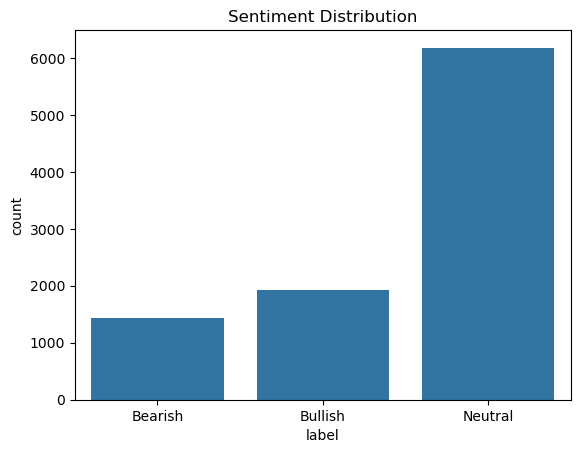

In [10]:
sns.countplot(data=train_df, x='label')
plt.title("Sentiment Distribution")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

#### Creating clean text without stopwords for this analysis (temporary df)

In [11]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rbern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df_no_stopwords = train_df.copy()
df_no_stopwords['text'] = df_no_stopwords['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

Class 0:

In [13]:
df_no_stopwords[df_no_stopwords["label"] == 0]["text"] \
    .str.lower().str.split() \
    .explode() \
    .loc[lambda x: ~x.isin(stopwords)] \
    .value_counts() \
    .head(10)

text
-              210
stock          130
misses          85
u.s.            79
coronavirus     72
oil             67
price           63
market          63
shares          61
china           59
Name: count, dtype: int64

Class 1:

In [14]:
df_no_stopwords[df_no_stopwords["label"] == 1]["text"] \
    .str.lower().str.split() \
    .explode() \
    .loc[lambda x: ~x.isin(stopwords)] \
    .value_counts() \
    .head(10)

text
-          317
stock      231
beats      161
price      132
target     116
shares     110
u.s.       106
revenue    102
new         95
market      92
Name: count, dtype: int64

Class 2:

In [15]:
df_no_stopwords[df_no_stopwords["label"] == 2]["text"] \
    .str.lower().str.split() \
    .explode() \
    .loc[lambda x: ~x.isin(stopwords)] \
    .value_counts() \
    .head(10)

text
-           863
:           343
results     307
#stock      283
new         282
earnings    239
2019        225
dividend    224
reports     222
says        221
Name: count, dtype: int64

Note: We have a lot of -, this likely does not carry much information.

N-Gram Analysis:

In [16]:
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), max_features=30)
X_trigrams = trigram_vectorizer.fit_transform(train_df["text"])
print(trigram_vectorizer.get_feature_names_out())

['19 00pm gmt' 'alpha https co' 'beats on revenue' 'call or presentation'
 'conference call or' 'dividend https co' 'earnings conference call'
 'economy marketscreener https' 'edited transcript of' 'eps beats by'
 'eps misses by' 'hedge funds are' 'marketscreener https co'
 'misses on revenue' 'more https co' 'on revenue https' 'on seeking alpha'
 'price target raised' 'read more and' 'reading https co'
 'reports q3 results' 'results earnings call' 'revenue https co'
 'seeking alpha https' 'sign up for' 'stock https co'
 'stock market update' 'stock marketscreener https' 'stock price target'
 'target raised to']


- Many Trigrams include https; likely not semantically helpful.
- There are several financial phrases that could be strong indicators for certain classes.

### Character Level Patterns: Digits/Punctuation/ Emojis/ URLs

In [17]:
# Count digits
train_df["digit_count"] = train_df["text"].str.count(r"\d")

# Count punctuation
train_df["punct_count"] = train_df["text"].str.count(r"[^\w\s]")

# Count uppercase words
train_df["upper_count"] = train_df["text"].str.findall(r"\b[A-Z]{2,}\b").str.len()

#URL
train_df["has_url"] = train_df["text"].str.contains(r"http\S+", regex=True)
# Mentions
train_df["has_mention"] = train_df["text"].str.contains(r"@\w+", regex=True)
# Hashtags
train_df["has_hashtag"] = train_df["text"].str.contains(r"#\w+", regex=True)

# emojis
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
train_df["emoji_count"] = train_df["text"].apply(lambda x: len(emoji_pattern.findall(x)))

In [18]:
print(train_df["has_url"].value_counts())
print("Percentage of tweets with URLs:", train_df["has_url"].mean() * 100)
print("--------------------------")
print(train_df["has_mention"].value_counts())
print("Percentage of tweets with mentions:", train_df["has_mention"].mean() * 100)
print("--------------------------")
print(train_df["has_hashtag"].value_counts())
print("Percentage of tweets with hashtags:", train_df["has_hashtag"].mean() * 100)
print("--------------------------")

has_url
False    5073
True     4470
Name: count, dtype: int64
Percentage of tweets with URLs: 46.84061615844074
--------------------------
has_mention
False    9249
True      294
Name: count, dtype: int64
Percentage of tweets with mentions: 3.080792203709525
--------------------------
has_hashtag
False    8647
True      896
Name: count, dtype: int64
Percentage of tweets with hashtags: 9.38908100178141
--------------------------


In [19]:
train_df[["digit_count", "punct_count", "upper_count", "emoji_count"]].describe()

,digit_count,punct_count,upper_count,emoji_count
count,9543.000000,9543.000000,9543.000000,9543.000000
mean,2.250655,5.671382,0.724301,0.002829
std,2.605929,4.615066,1.296677,0.055056
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000
50%,2.000000,5.000000,0.000000,0.000000
75%,4.000000,9.000000,1.000000,0.000000
max,35.000000,28.000000,23.000000,2.000000


In [20]:
train_df.groupby("label")[["digit_count", "punct_count", "upper_count", "emoji_count"]].mean()

,digit_count,punct_count,upper_count,emoji_count
label,,,,
0,2.123440,5.269071,0.657420,0.000000
1,2.664067,5.515341,0.798232,0.000520
2,2.151667,5.813856,0.716899,0.004208


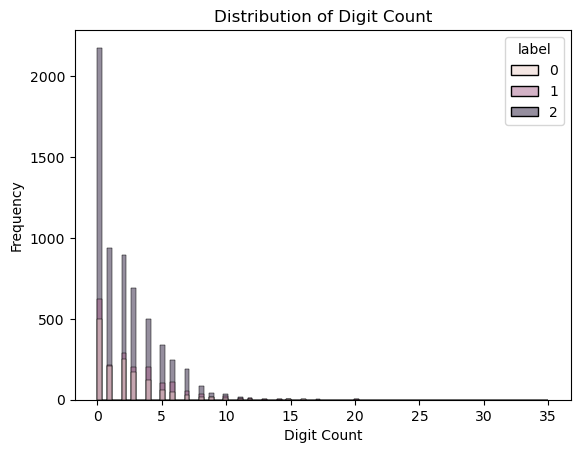

In [21]:
sns.histplot(data=train_df, x="digit_count", hue="label")
plt.title("Distribution of Digit Count")
plt.xlabel("Digit Count")
plt.ylabel("Frequency")
plt.show()

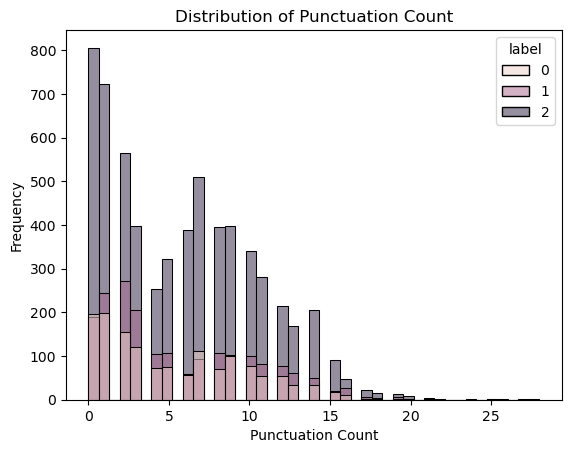

In [22]:
sns.histplot(data=train_df, x="punct_count", hue="label")
plt.title("Distribution of Punctuation Count")
plt.xlabel("Punctuation Count")
plt.ylabel("Frequency")
plt.show()

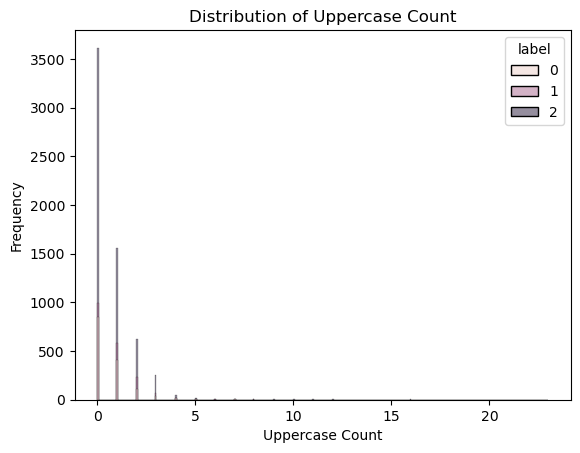

In [23]:
sns.histplot(data=train_df, x="upper_count", hue="label")
plt.title("Distribution of Uppercase Count")
plt.xlabel("Uppercase Count")
plt.ylabel("Frequency")
plt.show()

In [24]:
train_df.groupby("label")[["has_url", "has_mention", "has_hashtag"]].mean()

,has_url,has_mention,has_hashtag
label,,,
0,0.443135,0.020804,0.067961
1,0.391056,0.016121,0.061882
2,0.498381,0.037714,0.109906


- Positive Labels tend to have less URLs/Mentions/ and Hashtags

### Text Analysis

In [25]:
#checking random piece of text from our corpora.
train_df["text"][5]

'$FTI - TechnipFMC downgraded at Berenberg but called Top Pick at Deutsche Bank https://t.co/XKcPDilIuU'

In [26]:
train_df["label"][5]

0

- This particular piece of text chosen at random was classified as 0 -> Bearish.
- Perhaps word "downgraded" had an impact in classifying this piece of text.

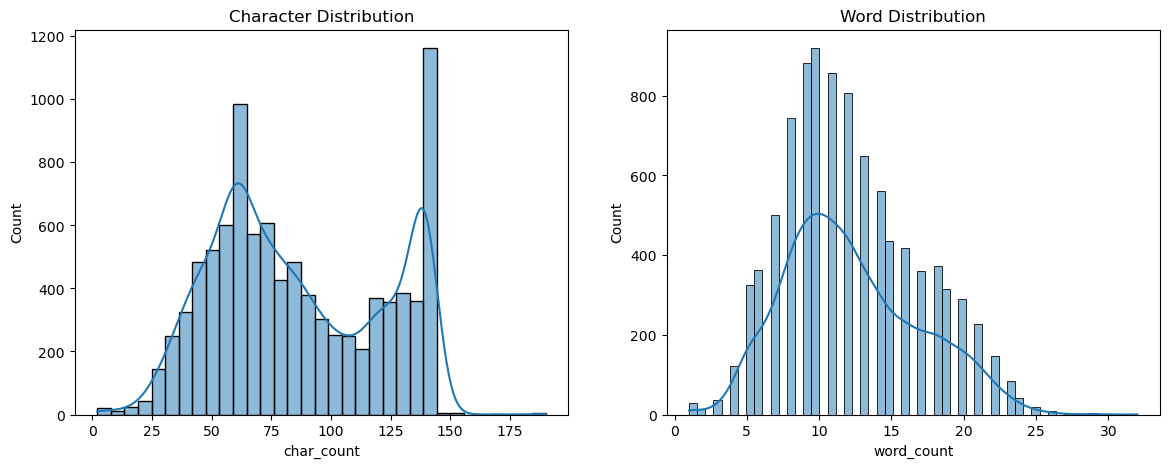

In [27]:
# len in characters
train_df['char_count'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(train_df['char_count'], kde=True, ax=axs[0]).set_title("Character Distribution")
sns.histplot(train_df['word_count'], kde=True, ax=axs[1]).set_title("Word Distribution")
plt.show()

#### Word Count

In [28]:
train_df['word_count']  = train_df['text'].apply(lambda x: len(str(x).split(" ")))
train_df[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [29]:
train_df["word_count"].describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

- Mean of 12 words per row.
- 31 words was the maximum word count.
- Minimum was 1 word, which we should check if these are relevant for our case.
- Most rows are comprised between 9 and 15 words.

In [30]:
train_df[train_df["word_count"] == 1]

,text,label,digit_count,punct_count,upper_count,has_url,has_mention,has_hashtag,emoji_count,char_count,word_count
1858,SASA聚酯选用英威达PTA技术,2,0,0,0,False,False,False,0,16,1
3943,:),2,0,2,0,False,False,False,0,2,1
3948,@TicToc,2,0,1,0,False,True,False,0,7,1
4360,Damn,2,0,0,0,False,False,False,0,4,1
4440,F5,2,1,0,0,False,False,False,0,2,1
4681,https://t.co/575AH1YRkF,2,4,5,0,True,False,False,0,23,1
4682,https://t.co/9eZPvQhfMq,2,1,5,0,True,False,False,0,23,1
4683,https://t.co/oJxNPEUpWq,2,0,5,0,True,False,False,0,23,1
5505,Wipro赢得Marelli的多年战略性IT协议,2,0,0,0,False,False,False,0,24,1
8290,$TSLA,2,0,1,1,False,False,False,0,5,1


Insights:
- Most rows are simply stock tickers, or a URL or emoji, or non-informative token...
- Removing these rows could be interesting, we could reduce noice, avoid overfitting to rare or meaningless terms.
- We can try to use models where we include these rows, some models might benefit from this other might not. We will iteratively try this and come back to this later.

Yet its important to note that rows that are just tickers, and are labeled as "positive" does not seem right...

In [31]:
train_df[train_df["word_count"] == 2]

,text,label,digit_count,punct_count,upper_count,has_url,has_mention,has_hashtag,emoji_count,char_count,word_count
3090,Brent +4%,1,1,2,0,False,False,False,0,9,2
3945,@MikeCaymanTrades sometimes,2,0,1,0,False,True,False,0,27,2
3980,100% Correct!,2,3,2,0,False,False,False,0,13,2
4914,Next week.,2,0,1,0,False,False,False,0,10,2
5484,Wholesale Trade,2,0,0,0,False,False,False,0,15,2
5512,Woke Sachs,2,0,0,0,False,False,False,0,10,2
5654,$penn coin,2,0,1,0,False,False,False,0,10,2
6511,Housing Starts,2,0,0,0,False,False,False,0,14,2
7276,Kudlow https://t.co/owfUNJQzrb,2,0,5,0,True,False,False,0,30,2
7935,$WW heavy....,1,0,5,1,False,False,False,0,13,2


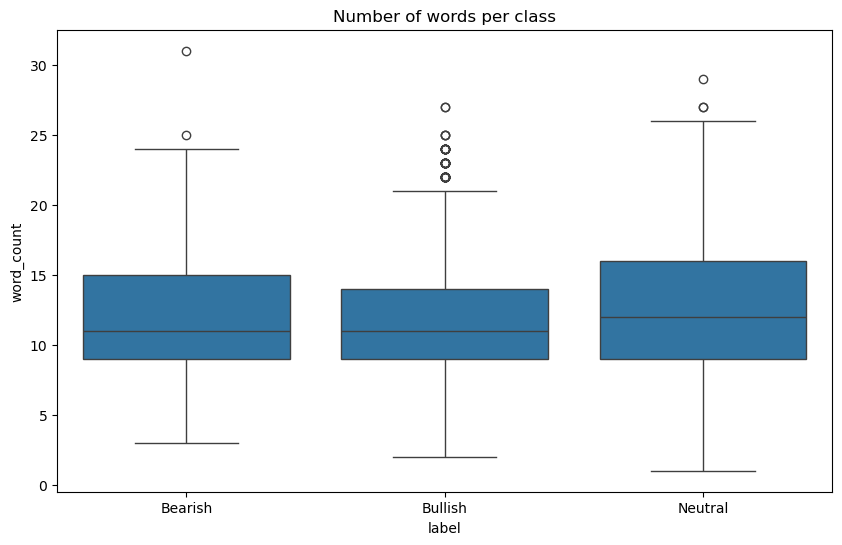

In [32]:
# len by class
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='word_count', data=train_df)
plt.title("Number of words per class")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

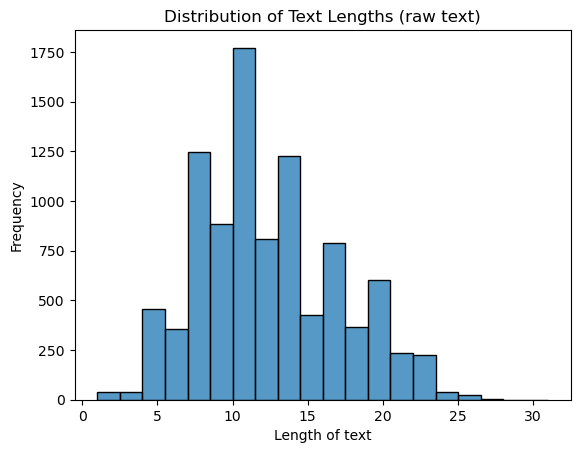

In [33]:
sns.histplot(train_df['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

Individual Words

In [34]:
all_words = ' '.join(train_df['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:15]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
at      539
as      528
is      526
by      414
up      388
Name: count, dtype: int64

- Naturally the most prominent words are stop words... Might be interesting to remove them in preprocessing as they do not carry much semantics.

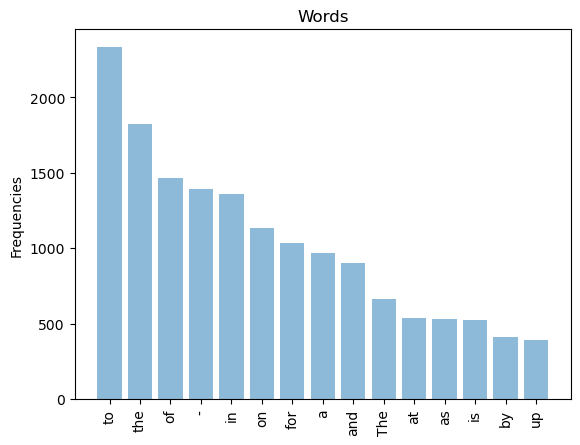

In [35]:
x_labels = freq.index[0:15]
values = freq[:15]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

Rare Words

In [36]:
rare_words = ' '.join(train_df['text']).split()
freq = pd.Series(rare_words).value_counts()
freq.sort_values(ascending=True)[0:25]

alert                      1
Landfill                   1
RNG                        1
Greenleaf                  1
Foods,                     1
SPC,                       1
Carrot                     1
Plant-based                1
Customers                  1
Nationwide                 1
#Grifols                   1
https://t.co/Dnt4oYb4SP    1
founder:                   1
$7.0                       1
‘I                         1
dreaming                   1
consolidation’             1
https://t.co/AB1CLG5Hfa    1
https://t.co/St0OvagWyy    1
Renewables                 1
Greenlane                  1
forward                    1
BMW                        1
Goldrea                    1
Dixie                      1
Name: count, dtype: int64

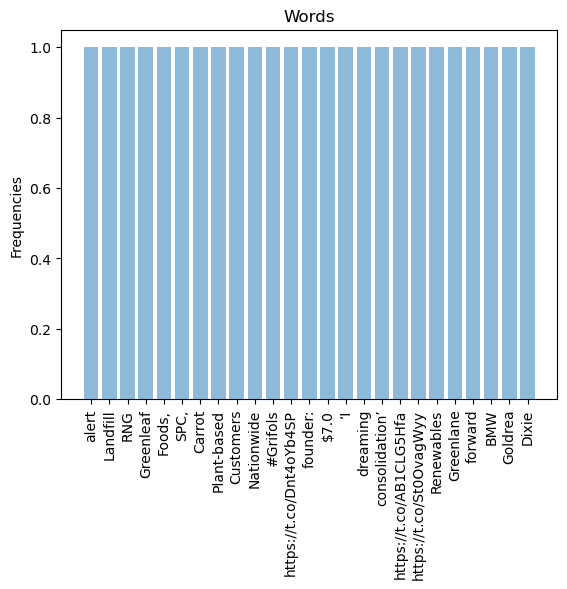

In [37]:
freq = freq.sort_values(ascending=True)
x_labels = freq.index[0:25]
values = freq[:25]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

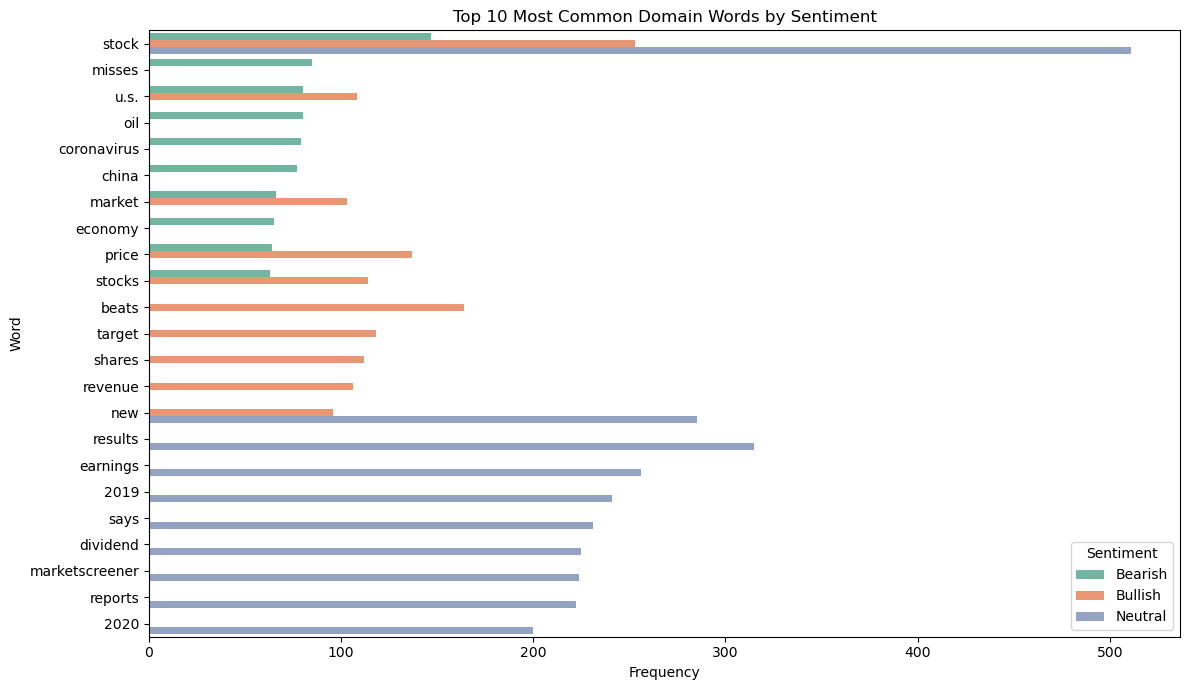

In [ ]:

# stopwords and irrelevant words
stop_words = set(stopwords.words('english'))
custom_stopwords = stop_words.union({'https', 't.co', 'co', 'amp', 'rt', 'u', 's', '’', '“', '”', '’s', '—', '…', "'s"})

def tokenize(text):
    tokens = word_tokenize(text.lower())
    return [t for t in tokens if t not in string.punctuation and t not in custom_stopwords and not t.startswith('http')]

# Aplica a tokenização
train_df['tokens'] = train_df['text'].astype(str).apply(tokenize)

# Mapeia os labels para nomes
label_map = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
train_df['label_name'] = train_df['label'].map(label_map)

# Conta as palavras mais comuns por label
top_words_per_label = {}
for label in train_df['label_name'].unique():
    tokens = train_df[train_df['label_name'] == label]['tokens']
    flat_tokens = [token for sublist in tokens for token in sublist]
    freq = Counter(flat_tokens).most_common(10)
    top_words_per_label[label] = freq

# Constrói DataFrame para visualização
top_words_df = pd.DataFrame([
    {'Label': label, 'Word': word, 'Frequency': freq}
    for label, words in top_words_per_label.items()
    for word, freq in words
])


plt.figure(figsize=(12, 7))
sns.barplot(data=top_words_df, x='Frequency', y='Word', hue='Label', palette='Set2')
plt.title('Top 10 Most Common Domain Words by Sentiment')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [61]:
del train_df['label_name']
del train_df['tokens']

## WordClouds

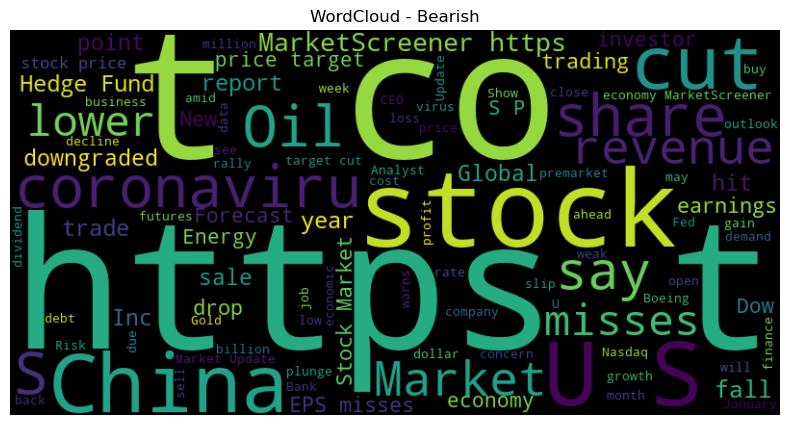

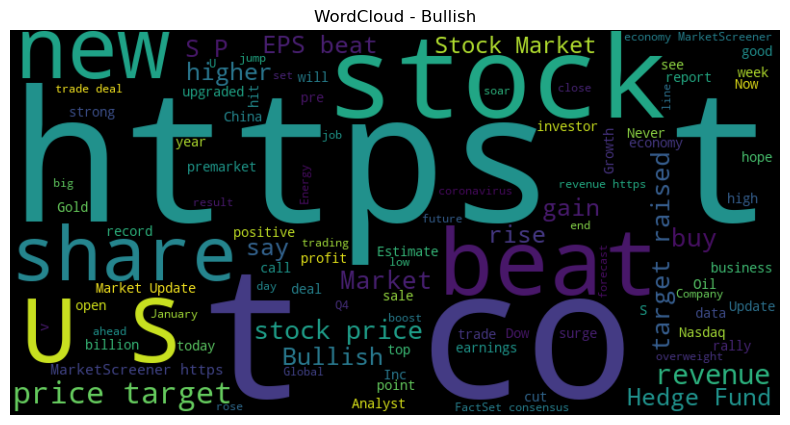

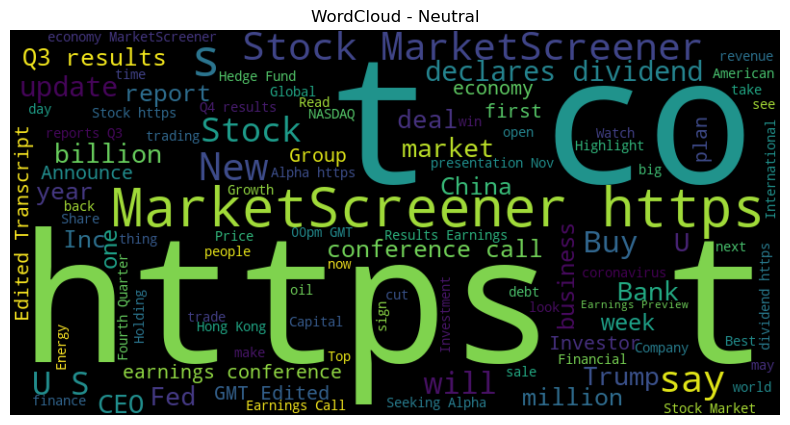

In [38]:
# function for wordcloud by class
def show_wordcloud(data, label_name):
    text = " ".join(data)
    wordcloud = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - {label_name}")
    plt.show()

for label, name in zip([0,1,2], ['Bearish', 'Bullish', 'Neutral']):
    show_wordcloud(train_df[train_df['label'] == label]['text'], name)

## Noisy Data

In [39]:
# aux functions
train_df['has_url'] = train_df['text'].apply(lambda x: int(bool(re.search(r"http\S+|www\S+", x))))
train_df['has_hashtag'] = train_df['text'].apply(lambda x: int(bool(re.search(r"#\w+", x))))
train_df['has_mention'] = train_df['text'].apply(lambda x: int(bool(re.search(r"@\w+", x))))
train_df['has_noise'] = train_df['text'].apply(lambda x: int(bool(re.search(r"[^\w\s,]", x))))

# percentages
for col in ['has_url', 'has_hashtag', 'has_mention', 'has_noise']:
    print(f"{col}: {train_df[col].mean():.2%}")

# duplicates
print(f"\nTextos duplicados: {train_df.duplicated('text').sum()} ({train_df.duplicated('text').mean():.2%})")

has_url: 46.84%
has_hashtag: 9.39%
has_mention: 3.08%
has_noise: 85.35%

Textos duplicados: 0 (0.00%)


In [40]:
train_df["text"][0]

'$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT'

## Correlations and Key Words

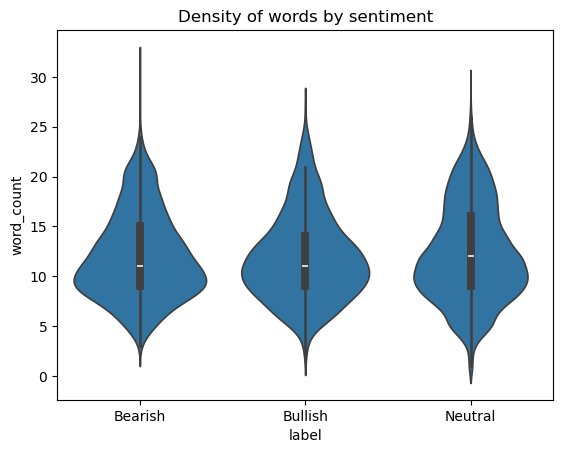

In [41]:
# correlation between n of words and lable
sns.violinplot(x='label', y='word_count', data=train_df)
plt.title("Density of words by sentiment")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()


# ACHO QUE JA TEMOS ISTO EM CIMA.

# def top_words_per_class(df, label):
#     text = " ".join(df[df['label'] == label]['text'])
#     words = re.findall(r'\b\w+\b', text.lower())
#     common = Counter(words).most_common(15)
#     return pd.DataFrame(common, columns=['word', 'count'])

# for label, name in zip([0,1,2], ['Bearish', 'Bullish', 'Neutral']):
#     print(f"\nTop words - {name}")
#     display(top_words_per_class(train_df, label))


*Top Words without stop words*

## Important Takeaways

- URLS: Most URLS dont carry meaning. We can indicate that to the model by replacing the URL with something like "URL".

- MENTIONS: Same

- Hashtags: Words in the # might be insightful, yet the # itself is not relevant, same for punctuation.

- Punctuation: ! or ? Could be insightful as it expresses sentiment or doubt or excitment. Yet things like =, -, _ are not as relevant

- Lowercasing : Necessary

# Corpus Split

In [42]:
df_train, df_val = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['label']
)

In [43]:
df_train['label'].value_counts(normalize=True), df_val['label'].value_counts(normalize=True)

(label
 2    0.647367
 1    0.201467
 0    0.151166
 Name: proportion, dtype: float64,
 label
 2    0.647459
 1    0.201676
 0    0.150864
 Name: proportion, dtype: float64)


# Data Preprocessing

## Encoders

In [44]:
def prepare_for_bert(text):
    text = re.sub(r"http\S+|www\S+", "[URL]", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def detect_signals(text):
    return {
        'has_url': int(bool(re.search(r"http\S+|www\S+", text))),
        'has_hashtag': int(bool(re.search(r"#\w+", text))),
        'has_mention': int(bool(re.search(r"@\w+", text))),
        'has_cashtag': int(bool(re.search(r"\$\w+", text))),
        'has_emoji': int(emoji.emoji_count(text) > 0)
    }

def enrich_text(row):
    text = row['bert_text']
    tags = []
    if row['has_emoji']:
        tags.append("This tweet contains emojis.")
    if row['has_url']:
        tags.append("This tweet contains a URL.")
    if row['has_cashtag']:
        tags.append("This tweet contains a cashtag.")
    if row['has_hashtag']:
        tags.append("This tweet contains a hashtag.")
    enriched_intro = " ".join(tags)
    return enriched_intro + " " + text if tags else text

In [45]:
def preprocess_dataframe(df):
    df = df.copy()
    df['bert_text'] = df['text'].apply(prepare_for_bert)
    signal_cols = df['text'].apply(detect_signals).apply(pd.Series)
    df = pd.concat([df, signal_cols], axis=1)
    df['bert_text_enriched'] = df.apply(enrich_text, axis=1)
    return df

In [ ]:
df_proc = preprocess_dataframe(train_df)


# Feature Engineering

## Enconders

In [ ]:
def prepare_hf_datasets(df, tokenizer):
    df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

    train_data = Dataset.from_pandas(df_train[['bert_text_enriched', 'label']].rename(columns={'bert_text_enriched': 'text'}))
    val_data = Dataset.from_pandas(df_val[['bert_text_enriched', 'label']].rename(columns={'bert_text_enriched': 'text'}))

    def tokenize_function(example):
        return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

    train_tokenized = train_data.map(tokenize_function, batched=True)
    val_tokenized = val_data.map(tokenize_function, batched=True)

    train_tokenized.set_format("torch")
    val_tokenized.set_format("torch")

    return train_tokenized, val_tokenized


# Classification Models

## Encoders

In [ ]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.asarray(np.argmax(logits, axis=-1))
    labels = np.asarray(labels)

    return {
        "eval_accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "eval_precision_macro": precision_metric.compute(predictions=predictions, references=labels, average="macro")["precision"],
        "eval_recall_macro": recall_metric.compute(predictions=predictions, references=labels, average="macro")["recall"],
        "eval_f1_macro": f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"],
        "eval_precision_weighted": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "eval_recall_weighted": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "eval_f1_weighted": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"],
    }

In [ ]:
def train_encoder_model(df, model_checkpoint):
    # Usar tokenizer adequado (BERTweet precisa de use_fast=False)
    tokenizer = AutoTokenizer.from_pretrained(
        model_checkpoint,
        use_fast=False if "bertweet" in model_checkpoint else True
    )

    train_tokenized, val_tokenized = prepare_hf_datasets(df, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

    training_args = TrainingArguments(
        output_dir="./results_roberta",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        logging_dir="./logs_roberta",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    return trainer

### RoBERTa-Base

In [ ]:
trainer_roberta_base = train_encoder_model(df_proc, model_checkpoint="roberta-base")

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


### RoBERTa-large

In [ ]:
trainer_roberta_large = train_encoder_model(df_proc, model_checkpoint="roberta-large")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.378300,0.306970,0.897328,0.861369,0.884237,0.872225,0.899801,0.897328,0.898132
2,0.250500,0.338463,0.877423,0.827945,0.890946,0.853589,0.892475,0.877423,0.880144
3,0.185600,0.305459,0.897328,0.874169,0.866101,0.869817,0.897431,0.897328,0.897172
4,0.119100,0.474166,0.880566,0.832090,0.896063,0.858621,0.893397,0.880566,0.883192


### DeBERTa-v3-base

In [ ]:
trainer_deberta_base = train_encoder_model(df_proc, model_checkpoint="microsoft/deberta-v3-base")


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.505500,0.372051,0.857517,0.818726,0.837460,0.820336,0.870946,0.857517,0.860291
2,0.272900,0.323248,0.877423,0.827947,0.881978,0.850980,0.888095,0.877423,0.880036
3,0.200600,0.365390,0.879518,0.831340,0.882422,0.852700,0.889893,0.879518,0.882097
4,0.119500,0.361918,0.887376,0.843143,0.887712,0.863087,0.894200,0.887376,0.889091
5,0.101100,0.490610,0.882661,0.835533,0.885031,0.857176,0.891357,0.882661,0.884554
6,0.055000,0.496483,0.894185,0.854006,0.884952,0.867735,0.899168,0.894185,0.895683
7,0.051800,0.532211,0.895233,0.860332,0.877184,0.867952,0.897798,0.895233,0.896099
8,0.014500,0.574292,0.894185,0.862126,0.873094,0.867346,0.895420,0.894185,0.894663
9,0.027600,0.593111,0.891042,0.853097,0.875027,0.863203,0.894040,0.891042,0.892058
10,0.012300,0.582759,0.896281,0.862062,0.878942,0.870190,0.897965,0.896281,0.896903


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

### DeBERTa-v3-large

In [ ]:
trainer_deberta_large = train_encoder_model(df_proc, model_checkpoint="microsoft/deberta-v3-large")


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.401700,0.349699,0.885804,0.845549,0.870302,0.856554,0.890649,0.885804,0.887169
2,0.261100,0.282744,0.903614,0.872004,0.886624,0.878628,0.905399,0.903614,0.904018
3,0.177400,0.337525,0.906234,0.872623,0.893591,0.882319,0.908866,0.906234,0.906945
4,0.085400,0.436160,0.904138,0.883738,0.872905,0.878175,0.903565,0.904138,0.903765
5,0.105900,0.459252,0.895757,0.867461,0.856920,0.860096,0.897906,0.895757,0.895613
6,0.036300,0.424457,0.910424,0.886647,0.884739,0.885677,0.910305,0.910424,0.910357
7,0.023100,0.553376,0.908853,0.899263,0.864893,0.880753,0.908544,0.908853,0.907715
8,0.008600,0.593730,0.913043,0.891217,0.884008,0.887556,0.912641,0.913043,0.912806
9,0.010900,0.581378,0.911996,0.883964,0.892093,0.887750,0.912955,0.911996,0.912284
10,0.003700,0.603972,0.913567,0.891347,0.883694,0.887409,0.913152,0.913567,0.913301


### BERTweet

In [ ]:
trainer_bertweet = train_encoder_model(df_proc, model_checkpoint="vinai/bertweet-base")


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.495100,0.429290,0.833944,0.773566,0.815637,0.790686,0.847098,0.833944,0.838112
2,0.365000,0.397468,0.857517,0.803833,0.847762,0.822010,0.869599,0.857517,0.860474
3,0.246500,0.359491,0.878470,0.836937,0.851027,0.843280,0.880897,0.878470,0.879327
4,0.168000,0.388365,0.886328,0.842140,0.871407,0.855469,0.890882,0.886328,0.887812
5,0.124200,0.426039,0.885804,0.841779,0.867904,0.854014,0.889536,0.885804,0.887096
6,0.088300,0.455851,0.895233,0.871103,0.849931,0.859985,0.893916,0.895233,0.894244
7,0.057000,0.509042,0.889995,0.854367,0.863492,0.858028,0.892289,0.889995,0.890694
8,0.041900,0.556002,0.889995,0.856342,0.858813,0.857388,0.890366,0.889995,0.890069
9,0.025000,0.555196,0.894709,0.864240,0.861519,0.862809,0.894527,0.894709,0.894583
10,0.023800,0.559687,0.894185,0.861676,0.864204,0.862931,0.894421,0.894185,0.894298


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

### MPNet-base

In [ ]:
trainer_mpnetbase = train_encoder_model(df_proc, model_checkpoint="microsoft/mpnet-base")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/472k [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.525100,0.427198,0.860136,0.832085,0.805736,0.817872,0.858300,0.860136,0.858625
2,0.375900,0.329160,0.881613,0.848798,0.851213,0.849935,0.881903,0.881613,0.881714
3,0.288300,0.310845,0.888423,0.855285,0.863279,0.858579,0.890229,0.888423,0.888977
4,0.225100,0.351312,0.875851,0.827760,0.881118,0.849563,0.887352,0.875851,0.878609
5,0.184900,0.369605,0.879518,0.831677,0.882195,0.853804,0.888553,0.879518,0.881630
6,0.126300,0.397917,0.893138,0.857640,0.873151,0.864935,0.895108,0.893138,0.893870
7,0.091400,0.380931,0.897852,0.871426,0.869338,0.870353,0.897738,0.897852,0.897777
8,0.080500,0.414381,0.894709,0.861552,0.875431,0.868159,0.896175,0.894709,0.895258
9,0.079100,0.432807,0.891042,0.853483,0.877703,0.864795,0.893998,0.891042,0.892028
10,0.060100,0.440387,0.892614,0.857497,0.874352,0.865418,0.894611,0.892614,0.893331


### ALBERT-base-v2

In [ ]:
trainer_albert_base = train_encoder_model(df_proc, model_checkpoint="albert-base-v2")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.538300,0.487640,0.827135,0.794208,0.742326,0.763999,0.823756,0.827135,0.822273
2,0.383300,0.383746,0.858565,0.824894,0.803139,0.813355,0.856591,0.858565,0.857179
3,0.258800,0.422300,0.859089,0.828391,0.810737,0.817872,0.859551,0.859089,0.858229
4,0.154400,0.445809,0.869565,0.837437,0.821599,0.828262,0.869191,0.869565,0.868767
5,0.079300,0.641659,0.862232,0.815668,0.843503,0.826660,0.869008,0.862232,0.864103
6,0.064000,0.665071,0.868518,0.822913,0.846499,0.833940,0.872079,0.868518,0.869805
7,0.030500,0.785193,0.869041,0.838846,0.824751,0.829861,0.870094,0.869041,0.868382
8,0.020700,0.821437,0.867994,0.832948,0.828410,0.830491,0.867644,0.867994,0.867700
9,0.005200,0.852527,0.868518,0.835826,0.826004,0.830551,0.867860,0.868518,0.867939


### Ensemble

#### RoBERTa-large + DeBERTa-v3-large

In [ ]:
from sklearn.metrics import f1_score

def find_best_ensemble_weight(probas_a, probas_b, y_true, step=0.01):
    best_f1 = 0
    best_w = 0
    for w in np.arange(0, 1 + step, step):
        ensemble = w * probas_a + (1 - w) * probas_b
        preds = np.argmax(ensemble, axis=1)
        f1 = f1_score(y_true, preds, average="macro")
        if f1 > best_f1:
            best_f1 = f1
            best_w = w
    return best_w, best_f1



In [ ]:
# 1. Obter previsões de ambos os modelos
probas_deberta = trainer_deberta_large.predict(trainer_deberta_large.eval_dataset).predictions
probas_roberta = trainer_roberta_large.predict(trainer_roberta_large.eval_dataset).predictions
y_true = trainer_deberta_large.predict(trainer_deberta_large.eval_dataset).label_ids

# 2. Encontrar o melhor peso
best_w, best_f1 = find_best_ensemble_weight(probas_deberta, probas_roberta, y_true)

# 3. Calcular ensemble com esse peso
ensemble_probas = best_w * probas_deberta + (1 - best_w) * probas_roberta
ensemble_preds = np.argmax(ensemble_probas, axis=1)

# 4. Avaliar
print(f"\nBest ensemble weight: {best_w:.2f} (DeBERTa), {1-best_w:.2f} (RoBERTa)")
print(f"Macro F1-score: {best_f1:.4f}")
print("\nFull Classification Report:")
print(classification_report(y_true, ensemble_preds, target_names=['Bearish', 'Bullish', 'Neutral']))



Best ensemble weight: 0.26 (DeBERTa), 0.74 (RoBERTa)
Macro F1-score: 0.8907

Full Classification Report:
              precision    recall  f1-score   support

     Bearish       0.83      0.86      0.84       288
     Bullish       0.87      0.91      0.89       385
     Neutral       0.95      0.93      0.94      1236

    accuracy                           0.91      1909
   macro avg       0.88      0.90      0.89      1909
weighted avg       0.92      0.91      0.91      1909



### Grid Search Roberta-Large

In [ ]:
# save_path = "/content/drive/MyDrive/Text Mining/Project"
# optuna_db = f"sqlite:///{save_path}/optuna_study.db"
# study_name = "roberta_large_tuning"

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("roberta-large", use_fast=True)
# train_tokenized, val_tokenized = prepare_hf_datasets(df_proc, tokenizer)

# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=3)


# def hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
#         "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
#     }

# accuracy_metric = evaluate.load("accuracy")
# precision_metric = evaluate.load("precision")
# recall_metric = evaluate.load("recall")
# f1_metric = evaluate.load("f1")

# def compute_metrics_roberta(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)

#     return {
#         "eval_accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
#         "eval_precision_macro": precision_metric.compute(predictions=predictions, references=labels, average="macro")["precision"],
#         "eval_recall_macro": recall_metric.compute(predictions=predictions, references=labels, average="macro")["recall"],
#         "eval_f1_macro": f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"],
#         "eval_precision_weighted": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
#         "eval_recall_weighted": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
#         "eval_f1_weighted": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"],
#     }

# training_args = TrainingArguments(
#     output_dir="./optuna_results",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     num_train_epochs=10,
#     fp16=True,
#     save_total_limit=1,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_f1_macro",
#     greater_is_better=True,
#     logging_dir="./logs",
#     logging_steps=50,
#     report_to="none"
# )

# trainer = Trainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=train_tokenized,
#     eval_dataset=val_tokenized,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics_roberta,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
# )

# def compute_objective(metrics):
#     return metrics["eval_f1_macro"]

# best_trial = trainer.hyperparameter_search(
#     direction="maximize",
#     hp_space=hp_space,
#     compute_objective=compute_objective,
#     backend="optuna",
#     n_trials=200,
#     study_name=study_name,
#     storage=optuna_db,
#     load_if_exists=True
# )

# with open(f"{save_path}/best_hyperparameters.json", "w") as f:
#     json.dump(best_trial.hyperparameters, f, indent=4)

# study = optuna.load_study(study_name=study_name, storage=optuna_db)
# df_trials = study.trials_dataframe()
# df_trials = df_trials.rename(columns={"value": "f1_macro"})
# df_trials.to_csv(f"{save_path}/optuna_trials.csv", index=False)


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-09 06:25:33,259] A new study created in RDB with name: roberta_large_tuning
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.284500,0.354379,0.872708,0.829268,0.867946,0.846266,0.879183,0.872708,0.874515
2,0.288600,0.435279,0.874804,0.825819,0.894619,0.853792,0.890583,0.874804,0.877480
3,0.183100,0.452630,0.903091,0.863447,0.903817,0.881818,0.908379,0.903091,0.904373
4,0.233300,0.457615,0.907281,0.874745,0.895880,0.884825,0.909288,0.907281,0.907952
5,0.280200,0.555544,0.902043,0.864315,0.895580,0.878871,0.905663,0.902043,0.903046
6,0.086800,0.658348,0.898900,0.858401,0.897817,0.876332,0.904209,0.898900,0.900195
7,0.190400,0.597235,0.904138,0.873334,0.888378,0.880363,0.905549,0.904138,0.904479


[I 2025-06-09 06:39:38,755] Trial 0 finished with value: 0.8803629897797766 and parameters: {'learning_rate': 2.319521017201859e-06, 'per_device_train_batch_size': 8, 'weight_decay': 0.090220517190935}. Best is trial 0 with value: 0.8803629897797766.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.387200,0.314820,0.891042,0.876733,0.846199,0.859940,0.890890,0.891042,0.889851
2,0.250100,0.327201,0.889471,0.840671,0.901574,0.866631,0.900774,0.889471,0.891730
3,0.220500,0.400307,0.897852,0.852505,0.908566,0.876775,0.907379,0.897852,0.899676
4,0.139900,0.448904,0.891566,0.847038,0.894016,0.867877,0.898903,0.891566,0.893368
5,0.085900,0.532814,0.908853,0.877629,0.893468,0.884993,0.910539,0.908853,0.909283
6,0.080400,0.625509,0.902043,0.859646,0.903304,0.879291,0.908250,0.902043,0.903474
7,0.098100,0.657553,0.902043,0.859373,0.903861,0.879267,0.908503,0.902043,0.903652
8,0.054200,0.670313,0.906234,0.870360,0.897433,0.883098,0.909158,0.906234,0.907098


[I 2025-06-09 06:48:50,112] Trial 1 finished with value: 0.8830980451327668 and parameters: {'learning_rate': 5.478474483308474e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.18409586444075288}. Best is trial 1 with value: 0.8830980451327668.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.807800,0.652708,0.733368,0.676541,0.504379,0.507278,0.713739,0.733368,0.679002
2,0.381500,0.293289,0.885804,0.859104,0.856947,0.857778,0.885868,0.885804,0.885708
3,0.316900,0.266029,0.893662,0.870119,0.867815,0.868715,0.893776,0.893662,0.893589
4,0.251000,0.269022,0.894709,0.858917,0.891727,0.873520,0.899026,0.894709,0.895840
5,0.218600,0.273881,0.895233,0.857859,0.889094,0.872348,0.899055,0.895233,0.896277
6,0.200100,0.295425,0.889995,0.844451,0.900043,0.868603,0.899241,0.889995,0.891913
7,0.193400,0.276027,0.900471,0.866018,0.893858,0.879076,0.903391,0.900471,0.901340
8,0.179000,0.279898,0.899948,0.866632,0.892421,0.878726,0.902671,0.899948,0.900687
9,0.157700,0.280772,0.902043,0.869515,0.892904,0.880564,0.904385,0.902043,0.902715
10,0.140400,0.291987,0.896805,0.859723,0.894646,0.875834,0.900968,0.896805,0.897874


[I 2025-06-09 06:56:16,668] Trial 2 finished with value: 0.8758342088883372 and parameters: {'learning_rate': 1.7490141631741543e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.20313565872186637}. Best is trial 1 with value: 0.8830980451327668.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.423300,0.338935,0.878470,0.858342,0.835884,0.846447,0.877502,0.878470,0.877485
2,0.289900,0.329029,0.868518,0.817873,0.891409,0.846584,0.888056,0.868518,0.871607
3,0.195600,0.287403,0.905186,0.868717,0.899240,0.882968,0.908639,0.905186,0.906182
4,0.129800,0.501723,0.858565,0.803160,0.890976,0.834769,0.886674,0.858565,0.863680
5,0.096500,0.453877,0.903614,0.874976,0.877404,0.876098,0.903774,0.903614,0.903638
6,0.056700,0.501618,0.902043,0.862019,0.903835,0.880542,0.908027,0.902043,0.903543


[I 2025-06-09 07:00:48,797] Trial 3 finished with value: 0.8805419408460985 and parameters: {'learning_rate': 1.1201952711217446e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.2547816985156166}. Best is trial 1 with value: 0.8830980451327668.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.283900,0.341033,0.894185,0.864253,0.871876,0.867592,0.895325,0.894185,0.894521
2,0.296100,0.510692,0.887899,0.843211,0.900804,0.866896,0.900376,0.887899,0.889970
3,0.160300,0.465136,0.912520,0.880244,0.907188,0.892916,0.915236,0.912520,0.913266
4,0.150300,0.519577,0.909377,0.873994,0.905544,0.888045,0.913865,0.909377,0.910643
5,0.137100,0.601861,0.908853,0.874978,0.903207,0.888167,0.911789,0.908853,0.909716
6,0.022200,0.623080,0.911996,0.880051,0.905447,0.892043,0.914410,0.911996,0.912664


[I 2025-06-09 07:12:51,160] Trial 4 finished with value: 0.8920427340338818 and parameters: {'learning_rate': 4.9687541734497985e-06, 'per_device_train_batch_size': 8, 'weight_decay': 0.29657407590307905}. Best is trial 4 with value: 0.8920427340338818.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.323200,0.383111,0.887899,0.856249,0.865380,0.860539,0.888888,0.887899,0.888256
2,0.292000,0.484098,0.889471,0.844496,0.894473,0.866337,0.897868,0.889471,0.891175
3,0.179500,0.498611,0.904662,0.886549,0.869319,0.877563,0.903892,0.904662,0.904060


[I 2025-06-09 07:18:40,965] Trial 5 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.811900,0.787404,0.647459,0.215820,0.333333,0.262003,0.419204,0.647459,0.508909


[I 2025-06-09 07:19:40,999] Trial 6 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.801700,0.660711,0.719749,0.688654,0.475415,0.463932,0.709646,0.719749,0.652680


[I 2025-06-09 07:20:16,439] Trial 7 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.622200,0.447549,0.852803,0.843478,0.772777,0.801963,0.852951,0.852803,0.848384


[I 2025-06-09 07:21:16,585] Trial 8 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.351300,0.317509,0.899948,0.898155,0.845736,0.868619,0.901060,0.899948,0.898066
2,0.237800,0.411139,0.884233,0.841513,0.895670,0.863014,0.897507,0.884233,0.886350
3,0.212200,0.469896,0.897328,0.866525,0.882779,0.873869,0.899560,0.897328,0.897877


[I 2025-06-09 07:24:32,949] Trial 9 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.278400,0.379317,0.886852,0.841769,0.893034,0.863711,0.895774,0.886852,0.888938
2,0.312300,0.524974,0.887376,0.844908,0.891340,0.863929,0.898051,0.887376,0.889355
3,0.155400,0.459006,0.905186,0.876795,0.888600,0.882209,0.906603,0.905186,0.905550


[I 2025-06-09 07:30:22,166] Trial 10 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.369000,0.298800,0.896281,0.878829,0.856697,0.867127,0.895358,0.896281,0.895453
2,0.220500,0.345020,0.881090,0.831308,0.906493,0.861077,0.899144,0.881090,0.883699
3,0.199100,0.328785,0.905710,0.865575,0.906967,0.884363,0.911103,0.905710,0.906964
4,0.113800,0.462340,0.895757,0.852541,0.899750,0.873543,0.902778,0.895757,0.897410
5,0.109100,0.509739,0.910424,0.875447,0.903446,0.888606,0.913360,0.910424,0.911266
6,0.087700,0.567868,0.904138,0.865466,0.900819,0.881717,0.908524,0.904138,0.905234
7,0.073900,0.630834,0.898376,0.857504,0.896977,0.875369,0.903766,0.898376,0.899607
8,0.035500,0.616909,0.907281,0.879710,0.887015,0.883170,0.907830,0.907281,0.907423


[I 2025-06-09 07:39:36,554] Trial 11 finished with value: 0.883170203183242 and parameters: {'learning_rate': 5.150255592034051e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.15337897801816427}. Best is trial 4 with value: 0.8920427340338818.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.280400,0.352374,0.891566,0.865011,0.864086,0.863877,0.892284,0.891566,0.891562
2,0.305000,0.458578,0.891042,0.849730,0.898858,0.869901,0.902059,0.891042,0.893014
3,0.180600,0.452545,0.912520,0.879780,0.908114,0.892473,0.916541,0.912520,0.913392
4,0.175800,0.488046,0.912520,0.885096,0.898259,0.891398,0.913640,0.912520,0.912925
5,0.232900,0.598921,0.906757,0.868974,0.910448,0.887772,0.912185,0.906757,0.907981
6,0.064400,0.601525,0.914615,0.889773,0.894912,0.892314,0.914960,0.914615,0.914769


[I 2025-06-09 07:51:39,193] Trial 12 finished with value: 0.8923139889070234 and parameters: {'learning_rate': 3.81697777162253e-06, 'per_device_train_batch_size': 8, 'weight_decay': 0.13247278801292817}. Best is trial 12 with value: 0.8923139889070234.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.322000,0.346675,0.905186,0.894910,0.863906,0.878274,0.905040,0.905186,0.904270
2,0.232900,0.598282,0.883185,0.836369,0.895409,0.860562,0.896478,0.883185,0.885475
3,0.120300,0.546885,0.904138,0.865654,0.903456,0.882980,0.908780,0.904138,0.905328


[I 2025-06-09 07:57:31,561] Trial 13 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.309100,0.339604,0.894709,0.870517,0.869470,0.869782,0.894804,0.894709,0.894639
2,0.284100,0.525445,0.871661,0.821019,0.895094,0.850357,0.890123,0.871661,0.874581
3,0.151100,0.452605,0.905186,0.866354,0.903438,0.883240,0.910077,0.905186,0.906335


[I 2025-06-09 08:03:20,806] Trial 14 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.403100,0.384886,0.865898,0.847092,0.811275,0.826953,0.865449,0.865898,0.864048


[I 2025-06-09 08:05:12,503] Trial 15 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.293900,0.350157,0.889471,0.858623,0.872086,0.864183,0.891615,0.889471,0.889963
2,0.316000,0.503921,0.876375,0.833267,0.894579,0.856590,0.894225,0.876375,0.879249


[I 2025-06-09 08:09:04,713] Trial 16 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.298700,0.428468,0.893138,0.867360,0.860950,0.863520,0.893675,0.893138,0.893028


[I 2025-06-09 08:10:55,542] Trial 17 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.479300,0.499698,0.865375,0.825911,0.823284,0.824250,0.865419,0.865375,0.865218


[I 2025-06-09 08:12:46,629] Trial 18 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.271300,0.323088,0.891042,0.868366,0.859858,0.863748,0.890800,0.891042,0.890682


[I 2025-06-09 08:14:37,602] Trial 19 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.345900,0.284936,0.893138,0.871088,0.855701,0.862690,0.892466,0.893138,0.892453
2,0.279100,0.267930,0.893138,0.853616,0.890146,0.869467,0.899438,0.893138,0.894390
3,0.188300,0.280406,0.905186,0.875007,0.891885,0.882401,0.907716,0.905186,0.905712
4,0.108200,0.329666,0.907805,0.867631,0.911571,0.887327,0.913707,0.907805,0.909218
5,0.076100,0.440522,0.904662,0.872519,0.892756,0.882200,0.906541,0.904662,0.905295
6,0.066800,0.479690,0.911996,0.879688,0.904813,0.891512,0.914411,0.911996,0.912731
7,0.042300,0.485224,0.909377,0.882553,0.890440,0.886425,0.909934,0.909377,0.909600
8,0.027400,0.571537,0.906757,0.867964,0.909839,0.886865,0.912078,0.906757,0.908040
9,0.038900,0.542220,0.911996,0.884998,0.895048,0.889918,0.912724,0.911996,0.912283


[I 2025-06-09 08:21:22,297] Trial 20 finished with value: 0.8899183469909365 and parameters: {'learning_rate': 8.532888797109945e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.12261504493687726}. Best is trial 12 with value: 0.8923139889070234.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.361600,0.290224,0.887376,0.855238,0.866925,0.860843,0.888640,0.887376,0.887876
2,0.263100,0.279857,0.895757,0.861656,0.887082,0.871333,0.901725,0.895757,0.896597
3,0.172700,0.269703,0.912520,0.884785,0.898324,0.890892,0.914167,0.912520,0.912879
4,0.123200,0.361886,0.892614,0.849688,0.893059,0.868965,0.899209,0.892614,0.894317
5,0.073200,0.414363,0.914091,0.886738,0.903889,0.894162,0.916720,0.914091,0.914597
6,0.076800,0.488475,0.905710,0.868038,0.903403,0.884192,0.910331,0.905710,0.906822
7,0.040400,0.491841,0.908329,0.874339,0.899425,0.886024,0.911074,0.908329,0.909032
8,0.026400,0.519573,0.912520,0.881919,0.898894,0.890087,0.913966,0.912520,0.912999


[I 2025-06-09 08:27:20,501] Trial 21 finished with value: 0.8900868631978495 and parameters: {'learning_rate': 8.517211410620076e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.12154149376065208}. Best is trial 12 with value: 0.8923139889070234.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.388300,0.302685,0.888947,0.870518,0.848114,0.858749,0.887988,0.888947,0.888045
2,0.250100,0.332666,0.878470,0.827032,0.903939,0.857805,0.896154,0.878470,0.881189


[I 2025-06-09 08:28:40,844] Trial 22 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.379300,0.275987,0.897852,0.872959,0.877340,0.875074,0.898183,0.897852,0.897981
2,0.276900,0.271586,0.896805,0.855741,0.896473,0.873714,0.903351,0.896805,0.898171
3,0.188800,0.267430,0.906757,0.874938,0.895649,0.884596,0.908957,0.906757,0.907320
4,0.122900,0.359393,0.888947,0.841410,0.905983,0.867368,0.902794,0.888947,0.891789
5,0.090800,0.361501,0.911472,0.884059,0.893929,0.888478,0.912623,0.911472,0.911702
6,0.082700,0.464968,0.904138,0.864752,0.906119,0.883525,0.909434,0.904138,0.905430
7,0.060400,0.480672,0.904662,0.864893,0.907607,0.884204,0.910326,0.904662,0.905935
8,0.042300,0.470849,0.912520,0.878778,0.903624,0.890523,0.915002,0.912520,0.913301
9,0.025900,0.501165,0.909900,0.875896,0.900792,0.887681,0.912392,0.909900,0.910679
10,0.018400,0.531002,0.904662,0.865534,0.903143,0.882780,0.909390,0.904662,0.905873


[I 2025-06-09 08:36:17,180] Trial 23 finished with value: 0.8827797779915546 and parameters: {'learning_rate': 7.2352945882556145e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.06476311432876819}. Best is trial 12 with value: 0.8923139889070234.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.591900,0.349643,0.869041,0.831417,0.840503,0.834930,0.871144,0.869041,0.869579


[I 2025-06-09 08:36:53,618] Trial 24 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.386200,0.429181,0.876375,0.842014,0.840449,0.840980,0.876520,0.876375,0.876306


[I 2025-06-09 08:38:44,600] Trial 25 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.418000,0.304006,0.886852,0.864131,0.852121,0.857963,0.886139,0.886852,0.886391


[I 2025-06-09 08:39:19,994] Trial 26 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.319500,0.364554,0.896281,0.878148,0.859296,0.867836,0.896279,0.896281,0.895660
2,0.308000,0.599417,0.867470,0.814868,0.893850,0.845296,0.888757,0.867470,0.870609
3,0.157000,0.547318,0.898376,0.873145,0.867275,0.870174,0.898028,0.898376,0.898175


[I 2025-06-09 08:45:10,173] Trial 27 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.273100,0.376258,0.872184,0.830227,0.867334,0.845230,0.879897,0.872184,0.874121


[I 2025-06-09 08:47:01,624] Trial 28 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.375700,0.303605,0.882661,0.852440,0.854111,0.853220,0.882951,0.882661,0.882778


[I 2025-06-09 08:47:37,461] Trial 29 pruned. 


Instead of a traditional grid search, we used Optuna to optimize the hyperparameters. One of its main advantages is that it allows us to resume the search exactly where it stopped in case the runtime is interrupted (e.g., GPU crashes, Colab disconnects, or kernel restarts).

The optuna_study.db file stores the full history of the optimization in a persistent SQLite database on Google Drive.

By setting load_if_exists=True, Optuna checks how many trials were already completed and continues the search only for the remaining ones without repeating anything. This allows us to build the final tuning progressively, in multiple sessions if needed, while keeping the process reproducible and efficient.

In [ ]:
study = optuna.load_study(
    study_name="roberta_large_tuning",
    storage="sqlite:////content/drive/MyDrive/Text Mining/Project/optuna_study.db"
)

print(f"Concluded trials: {len(study.trials)}")


Concluded trials: 83


cell below if we want to do runs from where it stopped (advantage of optuna)

In [ ]:
# best_trial = trainer.hyperparameter_search(
#     direction="maximize",
#     hp_space=hp_space,
#     compute_objective=compute_objective,
#     backend="optuna",
#     n_trials=200,
#     study_name=study_name,
#     storage=optuna_db,
#     load_if_exists=True
# )


[I 2025-06-09 09:14:16,377] Using an existing study with name 'roberta_large_tuning' instead of creating a new one.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.302900,0.351504,0.899424,0.863896,0.891517,0.876716,0.902591,0.899424,0.900391
2,0.349200,0.400777,0.909377,0.873875,0.906483,0.888828,0.913397,0.909377,0.910325
3,0.173400,0.480307,0.909377,0.871673,0.910935,0.889501,0.914393,0.909377,0.910478


[I 2025-06-09 09:20:10,204] Trial 32 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.356300,0.287784,0.886852,0.856774,0.856916,0.856625,0.886853,0.886852,0.886733


[I 2025-06-09 09:20:45,767] Trial 33 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.368000,0.293060,0.887376,0.851249,0.872873,0.861540,0.889753,0.887376,0.888178
2,0.269900,0.260971,0.901519,0.890412,0.860067,0.872096,0.902128,0.901519,0.900299
3,0.199000,0.263750,0.909377,0.877396,0.897606,0.886649,0.911684,0.909377,0.909890
4,0.143700,0.285150,0.904662,0.864052,0.905806,0.882881,0.910307,0.904662,0.906087
5,0.111200,0.363282,0.905710,0.875843,0.888338,0.880371,0.908406,0.905710,0.905960
6,0.091800,0.425431,0.902043,0.862532,0.901224,0.880185,0.906999,0.902043,0.903227


[I 2025-06-09 09:25:15,705] Trial 34 finished with value: 0.880185125223688 and parameters: {'learning_rate': 5.505915424790193e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.15350382809641555}. Best is trial 12 with value: 0.8923139889070234.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.442200,0.329182,0.876375,0.870333,0.817570,0.840821,0.876199,0.876375,0.873993


[I 2025-06-09 09:25:51,127] Trial 35 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.339500,0.285669,0.894709,0.864539,0.865945,0.865159,0.894989,0.894709,0.894807
2,0.266200,0.282685,0.889471,0.848718,0.882323,0.863149,0.895892,0.889471,0.890837


[I 2025-06-09 09:27:10,583] Trial 36 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.390800,0.305368,0.885280,0.864032,0.848027,0.855690,0.884645,0.885280,0.884707


[I 2025-06-09 09:27:46,018] Trial 37 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.576900,0.355221,0.866946,0.823089,0.851638,0.835918,0.871865,0.866946,0.868558


[I 2025-06-09 09:28:21,510] Trial 38 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.495100,0.354196,0.870613,0.863279,0.804255,0.830165,0.870002,0.870613,0.867758


[I 2025-06-09 09:29:21,100] Trial 39 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.871500,0.891588,0.647459,0.215820,0.333333,0.262003,0.419204,0.647459,0.508909


[I 2025-06-09 09:29:56,509] Trial 40 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.310300,0.346551,0.898376,0.879999,0.862772,0.870791,0.898250,0.898376,0.897886
2,0.279600,0.629481,0.875327,0.823817,0.900850,0.854217,0.894243,0.875327,0.878163
3,0.171200,0.479435,0.906757,0.878583,0.886428,0.882434,0.907324,0.906757,0.906986


[I 2025-06-09 09:35:46,314] Trial 41 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.437200,0.383231,0.887899,0.860671,0.856426,0.857384,0.888713,0.887899,0.887648


[I 2025-06-09 09:36:46,043] Trial 42 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.366300,0.288561,0.894709,0.864553,0.872197,0.868281,0.895398,0.894709,0.894982


[I 2025-06-09 09:37:45,782] Trial 43 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.353300,0.283522,0.895757,0.869986,0.867625,0.868141,0.896405,0.895757,0.895711


[I 2025-06-09 09:38:45,637] Trial 44 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.415400,0.322170,0.884233,0.848067,0.868527,0.856745,0.888121,0.884233,0.885386


[I 2025-06-09 09:39:45,368] Trial 45 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.386700,0.312869,0.887376,0.868265,0.847331,0.857345,0.886419,0.887376,0.886573


[I 2025-06-09 09:40:45,225] Trial 46 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.352000,0.311146,0.891042,0.888443,0.832870,0.857545,0.891203,0.891042,0.888885


[I 2025-06-09 09:41:44,778] Trial 47 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.271300,0.366113,0.894709,0.877016,0.855000,0.865249,0.893893,0.894709,0.893891
2,0.299700,0.619908,0.871137,0.820182,0.893645,0.849214,0.889693,0.871137,0.874082


[I 2025-06-09 09:45:36,503] Trial 48 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.377700,0.288177,0.898376,0.886840,0.858878,0.871570,0.898335,0.898376,0.897416
2,0.213900,0.469853,0.875851,0.825026,0.898470,0.853545,0.895410,0.875851,0.878810
3,0.221100,0.438622,0.899424,0.855326,0.899266,0.875076,0.905962,0.899424,0.901064


[I 2025-06-09 09:48:53,046] Trial 49 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.265000,0.376882,0.883185,0.842619,0.874532,0.857106,0.887681,0.883185,0.884531


[I 2025-06-09 09:50:43,530] Trial 50 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.403900,0.304395,0.888947,0.864278,0.855572,0.859844,0.888413,0.888947,0.888621


[I 2025-06-09 09:51:19,000] Trial 51 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.275500,0.353235,0.894709,0.864256,0.876306,0.869794,0.896139,0.894709,0.895180
2,0.349600,0.513055,0.882661,0.834295,0.899287,0.860991,0.896746,0.882661,0.884986
3,0.209300,0.485458,0.909377,0.879824,0.895779,0.887498,0.910784,0.909377,0.909846


[I 2025-06-09 09:57:06,855] Trial 52 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.376300,0.303919,0.888947,0.863756,0.858274,0.860615,0.888932,0.888947,0.888740


[I 2025-06-09 09:58:06,479] Trial 53 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.389400,0.318766,0.884233,0.853309,0.858458,0.855591,0.885110,0.884233,0.884526


[I 2025-06-09 09:59:06,108] Trial 54 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.473800,0.338952,0.872708,0.861372,0.811891,0.834101,0.871515,0.872708,0.870390


[I 2025-06-09 10:00:06,205] Trial 55 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.353900,0.317704,0.881613,0.897204,0.802208,0.841235,0.885072,0.881613,0.877574


[I 2025-06-09 10:01:06,153] Trial 56 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.308600,0.379053,0.895233,0.878732,0.851058,0.863977,0.894477,0.895233,0.894168
2,0.294600,0.563532,0.876899,0.826882,0.889523,0.851933,0.892422,0.876899,0.879494


[I 2025-06-09 10:04:56,530] Trial 57 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.441100,0.332666,0.877423,0.867955,0.817007,0.839783,0.876370,0.877423,0.875122


[I 2025-06-09 10:05:32,130] Trial 58 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.322200,0.420997,0.892090,0.865487,0.855706,0.860492,0.891404,0.892090,0.891677


[I 2025-06-09 10:07:22,689] Trial 59 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.660900,0.493538,0.839183,0.826363,0.744459,0.777874,0.837578,0.839183,0.833136


[I 2025-06-09 10:08:22,219] Trial 60 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.609700,0.398125,0.855422,0.809620,0.841507,0.822259,0.863769,0.855422,0.857831


[I 2025-06-09 10:08:57,646] Trial 61 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.288900,0.343013,0.898900,0.886308,0.858020,0.871365,0.898065,0.898900,0.897946
2,0.352800,0.544396,0.870089,0.825047,0.894019,0.850921,0.890432,0.870089,0.873069
3,0.151900,0.449851,0.911472,0.889696,0.883555,0.885978,0.911479,0.911472,0.911151


[I 2025-06-09 10:14:45,748] Trial 62 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.408700,0.324700,0.882661,0.874792,0.835301,0.851104,0.884918,0.882661,0.881094


[I 2025-06-09 10:15:21,202] Trial 63 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.407600,0.309871,0.880042,0.861535,0.837581,0.848718,0.879308,0.880042,0.879048


[I 2025-06-09 10:15:56,613] Trial 64 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.455000,0.335788,0.872184,0.825515,0.870683,0.845322,0.880272,0.872184,0.874362


[I 2025-06-09 10:16:32,136] Trial 65 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.410800,0.310764,0.878470,0.838657,0.867375,0.851968,0.882246,0.878470,0.879672


[I 2025-06-09 10:17:07,519] Trial 66 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.394200,0.298779,0.882661,0.853306,0.857053,0.854999,0.883196,0.882661,0.882839


[I 2025-06-09 10:17:43,022] Trial 67 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.417100,0.308204,0.886328,0.866074,0.841122,0.852547,0.885872,0.886328,0.885329


[I 2025-06-09 10:18:18,463] Trial 68 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.302200,0.409535,0.894709,0.869355,0.866236,0.867750,0.894562,0.894709,0.894605
2,0.362900,0.488236,0.892090,0.852317,0.888719,0.867800,0.899121,0.892090,0.893482
3,0.174400,0.441566,0.904138,0.871972,0.885384,0.878475,0.905303,0.904138,0.904565


[I 2025-06-09 10:24:07,028] Trial 69 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.438100,0.325082,0.870613,0.826458,0.868351,0.844288,0.878685,0.870613,0.872794


[I 2025-06-09 10:24:42,531] Trial 70 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.275300,0.335029,0.885280,0.846445,0.873557,0.859116,0.888642,0.885280,0.886367


[I 2025-06-09 10:26:33,839] Trial 71 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.362700,0.282204,0.902567,0.874487,0.877409,0.875811,0.903041,0.902567,0.902735
2,0.265300,0.348365,0.887899,0.838584,0.903124,0.865679,0.900420,0.887899,0.890371
3,0.232000,0.437402,0.900471,0.867110,0.884410,0.874816,0.903034,0.900471,0.901071


[I 2025-06-09 10:29:49,179] Trial 72 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.351400,0.301085,0.883709,0.843991,0.877783,0.859380,0.888294,0.883709,0.885038


[I 2025-06-09 10:30:24,732] Trial 73 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.486500,0.329344,0.876375,0.841013,0.856253,0.848074,0.878438,0.876375,0.876989


[I 2025-06-09 10:31:00,208] Trial 74 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.392000,0.303096,0.881090,0.846932,0.861330,0.853812,0.882730,0.881090,0.881663


[I 2025-06-09 10:31:35,666] Trial 75 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.338100,0.292034,0.889471,0.851552,0.878391,0.864136,0.892842,0.889471,0.890519
2,0.233100,0.333821,0.878994,0.826826,0.903917,0.857665,0.896795,0.878994,0.881775


[I 2025-06-09 10:32:54,313] Trial 76 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.545000,0.317125,0.882137,0.865863,0.839586,0.852010,0.881181,0.882137,0.881145


[I 2025-06-09 10:33:29,849] Trial 77 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.306500,0.352501,0.900995,0.881662,0.860608,0.870667,0.899991,0.900995,0.900186
2,0.356200,0.480373,0.895233,0.851550,0.912582,0.876871,0.907451,0.895233,0.897121
3,0.136900,0.471976,0.909900,0.878953,0.897241,0.887710,0.911572,0.909900,0.910439


[I 2025-06-09 10:39:17,926] Trial 78 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.391000,0.286976,0.897852,0.880692,0.863403,0.871748,0.897117,0.897852,0.897274
2,0.292600,0.293544,0.895233,0.850402,0.907813,0.874817,0.906066,0.895233,0.897204
3,0.180200,0.290991,0.902043,0.865883,0.897064,0.880276,0.905839,0.902043,0.903005


[I 2025-06-09 10:41:21,592] Trial 79 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.368000,0.314437,0.892614,0.886053,0.840237,0.861084,0.891982,0.892614,0.890904


[I 2025-06-09 10:42:21,148] Trial 80 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.296500,0.405740,0.896805,0.884944,0.842077,0.861354,0.896631,0.896805,0.895123


[I 2025-06-09 10:44:12,168] Trial 81 pruned. 
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.370400,0.269812,0.896281,0.862822,0.880996,0.871469,0.898152,0.896281,0.896949
2,0.260300,0.294892,0.893138,0.845993,0.902017,0.869999,0.903236,0.893138,0.894989


AssertionError: Should not reach.

#### Showing top-10 results

In [ ]:
import optuna

# Caminho para a base de dados
save_path = "/content/drive/MyDrive/Text Mining/Project"
optuna_db = f"sqlite:///{save_path}/optuna_study.db"
study_name = "roberta_large_tuning"

# Carregar estudo existente
study = optuna.load_study(study_name=study_name, storage=optuna_db)

df_trials_2 = study.trials_dataframe()
df_trials_2 = df_trials_2.rename(columns={"value": "f1_macro"})  # opcional para clareza
df_trials_2_sorted = df_trials_2.sort_values(by="f1_macro", ascending=False).reset_index(drop=True)
df_trials_2_sorted.head(10)


#### Running the best parameters

In [ ]:
def train_encoder_model_2(df, model_checkpoint):
    # Usar tokenizer adequado (BERTweet precisa de use_fast=False)
    tokenizer = AutoTokenizer.from_pretrained(
        model_checkpoint,
        use_fast=False if "bertweet" in model_checkpoint else True
    )

    train_tokenized, val_tokenized = prepare_hf_datasets(df, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

    training_args = TrainingArguments(
        output_dir="./results_roberta",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=0.000004,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=10,
        weight_decay=0.132473,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        logging_dir="./logs_roberta",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    return trainer

In [ ]:
trainer_roberta_large_2 = train_encoder_model_2(df_proc, model_checkpoint="roberta-large")

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.273600,0.350858,0.893662,0.857691,0.880231,0.868203,0.896320,0.893662,0.894545
2,0.296500,0.639854,0.858565,0.807434,0.888682,0.837316,0.883693,0.858565,0.862049
3,0.188500,0.455548,0.909900,0.889978,0.879118,0.884428,0.909390,0.909900,0.909557
4,0.163700,0.542059,0.898900,0.852937,0.910563,0.877774,0.908602,0.898900,0.900909
5,0.202200,0.591262,0.906757,0.871476,0.900671,0.885159,0.909847,0.906757,0.907628
6,0.076800,0.622969,0.911472,0.875957,0.907841,0.890801,0.914900,0.911472,0.912412
7,0.102800,0.653944,0.909900,0.877542,0.898764,0.887470,0.911969,0.909900,0.910408
8,0.017800,0.674947,0.912520,0.881849,0.901583,0.891238,0.914209,0.912520,0.912994
9,0.050000,0.679844,0.911472,0.886035,0.893307,0.889579,0.911965,0.911472,0.911649
10,0.020500,0.694470,0.909900,0.878929,0.897254,0.887731,0.911458,0.909900,0.910407


In [ ]:
evaluate_and_report(trainer_roberta_large_2, name="RoBERTa-large")


Results for RoBERTa-large

Validation Set:
              precision    recall  f1-score   support

     Bearish       0.83      0.85      0.84       288
     Bullish       0.87      0.93      0.90       385
     Neutral       0.95      0.92      0.93      1236

    accuracy                           0.91      1909
   macro avg       0.88      0.90      0.89      1909
weighted avg       0.91      0.91      0.91      1909


Training Set:
              precision    recall  f1-score   support

     Bearish       0.99      0.99      0.99      1154
     Bullish       0.99      0.99      0.99      1538
     Neutral       1.00      1.00      1.00      4942

    accuracy                           1.00      7634
   macro avg       0.99      0.99      0.99      7634
weighted avg       1.00      1.00      1.00      7634



### Grid Search DeBERTa-Large

In [ ]:
# # Paths e configuração
# save_path = "/content/drive/MyDrive/Text Mining/Project"
# optuna_db = f"sqlite:///{save_path}/optuna_study.db"
# study_name = "deberta_large_tuning"

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large", use_fast=False)

# def prepare_hf_datasets_stratified(df, tokenizer):
#     df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

#     train_data = Dataset.from_pandas(df_train[['bert_text_enriched', 'label']].rename(columns={'bert_text_enriched': 'text'}))
#     val_data = Dataset.from_pandas(df_val[['bert_text_enriched', 'label']].rename(columns={'bert_text_enriched': 'text'}))

#     def tokenize(example):
#         return tokenizer(example["text"], padding=True, truncation=True, max_length=128)

#     train_tokenized = train_data.map(tokenize, batched=True)
#     val_tokenized = val_data.map(tokenize, batched=True)

#     train_tokenized = train_tokenized.rename_column("label", "labels")
#     val_tokenized = val_tokenized.rename_column("label", "labels")

#     train_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
#     val_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

#     return train_tokenized, val_tokenized

# # Preparar dados
# train_tokenized, val_tokenized = prepare_hf_datasets_stratified(df_proc, tokenizer)

# # Modelo
# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-large", num_labels=3)

# # Espaço de hiperparâmetros
# def hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
#         "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
#         "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
#         "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "cosine_with_restarts", "polynomial"]),
#         "adam_beta1": trial.suggest_float("adam_beta1", 0.85, 0.95),
#         "adam_beta2": trial.suggest_float("adam_beta2", 0.98, 0.999),
#     }

# # Métricas
# accuracy_metric = evaluate.load("accuracy")
# precision_metric = evaluate.load("precision")
# recall_metric = evaluate.load("recall")
# f1_metric = evaluate.load("f1")

# def compute_metrics_roberta(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return {
#         "eval_accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
#         "eval_precision_macro": precision_metric.compute(predictions=predictions, references=labels, average="macro")["precision"],
#         "eval_recall_macro": recall_metric.compute(predictions=predictions, references=labels, average="macro")["recall"],
#         "eval_f1_macro": f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"],
#         "eval_precision_weighted": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
#         "eval_recall_weighted": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
#         "eval_f1_weighted": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"],
#     }

# # Argumentos de treino
# training_args = TrainingArguments(
#     output_dir="./optuna_results",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     num_train_epochs=10,
#     fp16=True,
#     save_total_limit=1,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_f1_macro",
#     greater_is_better=True,
#     logging_dir="./logs",
#     logging_steps=30,
#     report_to="none",
#     remove_unused_columns=False
# )

# # Trainer
# trainer = Trainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=train_tokenized,
#     eval_dataset=val_tokenized,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics_roberta,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
# )

# # Função objetivo
# def compute_objective(metrics):
#     return metrics["eval_f1_macro"]

# # Optuna tuning
# best_trial = trainer.hyperparameter_search(
#     direction="maximize",
#     hp_space=hp_space,
#     compute_objective=compute_objective,
#     backend="optuna",
#     n_trials=100,
#     study_name=study_name,
#     storage=optuna_db,
#     load_if_exists=True
# )

# with open(f"{save_path}/best_hyperparameters.json", "w") as f:
#     json.dump(best_trial.hyperparameters, f, indent=4)

# study = optuna.load_study(study_name=study_name, storage=optuna_db)
# df_trials = study.trials_dataframe()
# df_trials = df_trials.rename(columns={"value": "f1_macro"})
# df_trials.to_csv(f"{save_path}/optuna_trials.csv", index=False)

# print("\nBest Trial:")
# print("F1_macro:", best_trial.value)
# print("Params:")
# for k, v in best_trial.hyperparameters.items():
#     print(f"  {k}: {v}")

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-10 12:52:49,289] Using an existing study with name 'deberta_large_tuning' instead of creating a new one.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.472400,0.392484,0.881090,0.870352,0.823852,0.844118,0.881260,0.881090,0.878982


[I 2025-06-10 12:54:41,803] Trial 39 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.491400,0.371194,0.881613,0.867454,0.834204,0.848738,0.881803,0.881613,0.880207


[I 2025-06-10 12:56:32,938] Trial 40 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.738000,0.663018,0.747512,0.449099,0.541025,0.490122,0.642408,0.747512,0.690423


[I 2025-06-10 12:58:24,431] Trial 41 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.630800,0.689038,0.748559,0.448294,0.534411,0.487390,0.639541,0.748559,0.689611


[I 2025-06-10 13:01:47,014] Trial 42 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.838900,0.806097,0.647459,0.382538,0.333929,0.263680,0.520142,0.647459,0.509863


[I 2025-06-10 13:02:52,392] Trial 43 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.468800,0.344725,0.876375,0.838463,0.860601,0.847406,0.881113,0.876375,0.877667


[I 2025-06-10 13:04:44,201] Trial 44 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.625500,0.640188,0.751702,0.785411,0.538706,0.493305,0.792031,0.751702,0.692767


[I 2025-06-10 13:08:07,082] Trial 45 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.404300,0.378297,0.848612,0.795341,0.863543,0.821554,0.867465,0.848612,0.852781


[I 2025-06-10 13:09:12,079] Trial 46 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.601400,0.488701,0.871661,0.852476,0.812428,0.828548,0.872552,0.871661,0.869393


[I 2025-06-10 13:11:03,678] Trial 47 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.470300,0.484724,0.873756,0.858400,0.814394,0.832469,0.874355,0.873756,0.871268


[I 2025-06-10 13:14:25,263] Trial 48 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.363700,0.567042,0.878994,0.898736,0.793757,0.835677,0.882852,0.878994,0.874261


[I 2025-06-10 13:17:46,436] Trial 49 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.434100,0.524399,0.885280,0.862556,0.840291,0.850895,0.883959,0.885280,0.884240
2,0.290800,0.520384,0.871137,0.826159,0.862232,0.839031,0.884307,0.871137,0.873804


[I 2025-06-10 13:24:39,393] Trial 50 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.579300,0.636566,0.760084,0.457801,0.560016,0.501647,0.660678,0.760084,0.705111


[I 2025-06-10 13:28:01,297] Trial 51 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.413900,0.358877,0.871137,0.847703,0.826439,0.835762,0.870856,0.871137,0.870089


[I 2025-06-10 13:29:05,654] Trial 52 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.664600,0.644808,0.756417,0.457211,0.556340,0.500539,0.653453,0.756417,0.700002


[I 2025-06-10 13:32:27,483] Trial 53 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.503100,0.516214,0.830278,0.786903,0.789948,0.779358,0.842237,0.830278,0.830969


[I 2025-06-10 13:35:49,860] Trial 54 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.656000,0.647054,0.745940,0.452800,0.563465,0.497268,0.658454,0.745940,0.695357


[I 2025-06-10 13:36:54,027] Trial 55 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.384900,0.541994,0.881613,0.858593,0.842271,0.850074,0.880795,0.881613,0.880999
2,0.309900,0.414851,0.883709,0.850533,0.860067,0.853470,0.887264,0.883709,0.884344


[I 2025-06-10 13:43:55,639] Trial 56 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.381600,0.435606,0.881090,0.862704,0.838373,0.848678,0.881403,0.881090,0.879981


[I 2025-06-10 13:45:00,957] Trial 57 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.508900,0.359102,0.884233,0.852658,0.856987,0.854710,0.884793,0.884233,0.884457


[I 2025-06-10 13:46:53,493] Trial 58 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.683200,0.559681,0.827658,0.808098,0.712160,0.747311,0.823959,0.827658,0.818293


[I 2025-06-10 13:48:46,469] Trial 59 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.453600,0.326206,0.883185,0.861994,0.842445,0.850845,0.883576,0.883185,0.882460


[I 2025-06-10 13:50:38,552] Trial 60 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.667100,0.475060,0.848088,0.844810,0.753457,0.790121,0.848061,0.848088,0.841794


[I 2025-06-10 13:52:29,610] Trial 61 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.400900,0.579016,0.866422,0.841153,0.814273,0.826663,0.865468,0.866422,0.865161


[I 2025-06-10 13:55:52,071] Trial 62 pruned. 
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.347000,0.417416,0.893138,0.875073,0.853291,0.863695,0.892199,0.893138,0.892337
2,0.198700,0.491648,0.894709,0.868456,0.870435,0.869268,0.894999,0.894709,0.894751


In [ ]:
study = optuna.load_study(
    study_name="deberta_large_tuning",
    storage="sqlite:////content/drive/MyDrive/Text Mining/Project/optuna_study.db"
)

print(f"Concluded trials: {len(study.trials)}")

Concluded trials: 39


In [ ]:
study = optuna.load_study(study_name=study_name, storage=optuna_db)

df_trials_2 = study.trials_dataframe()
df_trials_2 = df_trials_2.rename(columns={"value": "f1_macro"})  # opcional para clareza
df_trials_2_sorted = df_trials_2.sort_values(by="f1_macro", ascending=False).reset_index(drop=True)
df_trials_2_sorted.head(10)

,number,f1_macro,datetime_start,datetime_complete,duration,params_adam_beta1,params_adam_beta2,params_learning_rate,params_lr_scheduler_type,params_num_train_epochs,params_per_device_train_batch_size,params_warmup_ratio,params_weight_decay,state
0,13,0.889025,2025-06-10 09:12:28.354990,2025-06-10 09:48:22.601703,0 days 00:35:54.246713,0.932045,0.985954,0.000008,linear,NaN,8,0.024802,0.170602,COMPLETE
1,8,0.886812,2025-06-10 08:26:23.402257,2025-06-10 08:36:21.725366,0 days 00:09:58.323109,0.875162,0.981087,0.000020,linear,NaN,32,0.073080,0.064089,COMPLETE
2,24,0.886151,2025-06-10 10:37:17.937127,2025-06-10 11:12:33.049920,0 days 00:35:15.112793,0.894611,0.998737,0.000012,polynomial,NaN,8,0.042151,0.220107,COMPLETE
3,0,0.882731,2025-06-10 06:55:16.006196,2025-06-10 07:11:22.602818,0 days 00:16:06.596622,NaN,NaN,0.000004,NaN,NaN,16,NaN,0.000023,COMPLETE
4,27,0.881887,2025-06-10 11:17:46.756092,2025-06-10 11:46:07.248022,0 days 00:28:20.491930,0.891684,0.996824,0.000013,polynomial,NaN,8,0.047182,0.217512,PRUNED
5,7,0.881839,2025-06-10 08:05:22.367597,2025-06-10 08:26:23.370593,0 days 00:21:01.002996,0.851722,0.983310,0.000017,cosine_with_restarts,NaN,8,0.017721,0.078151,COMPLETE
6,1,0.881127,2025-06-10 07:11:22.636167,2025-06-10 07:31:49.927008,0 days 00:20:27.290841,NaN,NaN,0.000010,NaN,NaN,16,NaN,0.297056,COMPLETE
7,21,0.879788,2025-06-10 10:03:34.759411,2025-06-10 10:35:08.021559,0 days 00:31:33.262148,0.893279,0.985526,0.000015,linear,NaN,8,0.043624,0.129280,PRUNED
8,28,0.875682,2025-06-10 11:46:07.271864,2025-06-10 11:56:32.135832,0 days 00:10:24.863968,0.890084,0.998632,0.000010,polynomial,NaN,8,0.011342,0.244792,PRUNED
9,32,0.846336,2025-06-10 12:04:19.343977,2025-06-10 12:07:41.809732,0 days 00:03:22.465755,0.884080,0.985086,0.000009,linear,NaN,8,0.062289,0.230942,PRUNED


#### Running the best parameters

In [ ]:
def train_encoder_model_3(df, model_checkpoint):
    # Usar tokenizer adequado (BERTweet precisa de use_fast=False)
    tokenizer = AutoTokenizer.from_pretrained(
        model_checkpoint,
        use_fast=False if "bertweet" in model_checkpoint else True
    )

    train_tokenized, val_tokenized = prepare_hf_datasets(df, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

    training_args = TrainingArguments(
        output_dir="./results_roberta",
        eval_strategy="epoch",
        save_strategy="epoch",
        # Parâmetros atualizados
        learning_rate=1.201444168269591e-05,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8, # Mantido igual ao original
        num_train_epochs=10, # Mantido igual ao original
        weight_decay=0.22010675217835377,
        warmup_ratio=0.04215100867099648,
        lr_scheduler_type='polynomial',
        adam_beta1=0.8946106863699657,
        adam_beta2=0.9987366748799633,
        # Restante dos parâmetros originais
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        logging_dir="./logs_roberta",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    return trainer

In [ ]:
trainer_deberta_large_2 = train_encoder_model_3(df_proc, model_checkpoint="microsoft/deberta-v3-large")

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.430600,0.387790,0.897328,0.899311,0.826909,0.858117,0.897618,0.897328,0.894467
2,0.304200,0.399662,0.895757,0.861006,0.877032,0.868128,0.898291,0.895757,0.896362
3,0.210000,0.479172,0.907281,0.876140,0.876585,0.875929,0.907759,0.907281,0.907279
4,0.108300,0.564121,0.902567,0.872672,0.876523,0.873967,0.903474,0.902567,0.902706
5,0.145900,0.590917,0.907281,0.876547,0.881028,0.878204,0.908160,0.907281,0.907364
6,0.074700,0.631283,0.908853,0.888810,0.868919,0.877848,0.908421,0.908853,0.908182


KeyboardInterrupt: 

In [ ]:
evaluate_and_report(trainer_deberta_large_2, name="DeBERTa-large")

# Evaluation

## Encoders

In [ ]:
def evaluate_and_report(trainer, name="Model"):
    # Validation predictions
    val_predictions = trainer.predict(trainer.eval_dataset)
    val_preds = np.argmax(val_predictions.predictions, axis=1)

    # Training predictions
    train_predictions = trainer.predict(trainer.train_dataset)
    train_preds = np.argmax(train_predictions.predictions, axis=1)

    # Print reports
    print(f"\nResults for {name}")
    print("\nValidation Set:")
    print(classification_report(val_predictions.label_ids, val_preds, target_names=['Bearish', 'Bullish', 'Neutral']))

    print("\nTraining Set:")
    print(classification_report(train_predictions.label_ids, train_preds, target_names=['Bearish', 'Bullish', 'Neutral']))

#### RoBERTa-Barge

In [ ]:
evaluate_and_report(trainer_roberta_base, name="RoBERTa-base")

#### RoBERTa-Large

In [ ]:
evaluate_and_report(trainer_roberta_large, name="RoBERTa-large")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.378300,0.306970,0.897328,0.861369,0.884237,0.872225,0.899801,0.897328,0.898132
2,0.250500,0.338463,0.877423,0.827945,0.890946,0.853589,0.892475,0.877423,0.880144
3,0.185600,0.305459,0.897328,0.874169,0.866101,0.869817,0.897431,0.897328,0.897172
4,0.119100,0.474166,0.880566,0.832090,0.896063,0.858621,0.893397,0.880566,0.883192


#### DeBERTa-v3-base

In [ ]:
evaluate_and_report(trainer_deberta_base, name="DeBERTa-v3-base")


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.505500,0.372051,0.857517,0.818726,0.837460,0.820336,0.870946,0.857517,0.860291
2,0.272900,0.323248,0.877423,0.827947,0.881978,0.850980,0.888095,0.877423,0.880036
3,0.200600,0.365390,0.879518,0.831340,0.882422,0.852700,0.889893,0.879518,0.882097
4,0.119500,0.361918,0.887376,0.843143,0.887712,0.863087,0.894200,0.887376,0.889091
5,0.101100,0.490610,0.882661,0.835533,0.885031,0.857176,0.891357,0.882661,0.884554
6,0.055000,0.496483,0.894185,0.854006,0.884952,0.867735,0.899168,0.894185,0.895683
7,0.051800,0.532211,0.895233,0.860332,0.877184,0.867952,0.897798,0.895233,0.896099
8,0.014500,0.574292,0.894185,0.862126,0.873094,0.867346,0.895420,0.894185,0.894663
9,0.027600,0.593111,0.891042,0.853097,0.875027,0.863203,0.894040,0.891042,0.892058
10,0.012300,0.582759,0.896281,0.862062,0.878942,0.870190,0.897965,0.896281,0.896903


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

#### DeBERTa-v3-large

In [ ]:
evaluate_and_report(trainer_deberta_large, name="DeBERTa-v3-large")


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.401700,0.349699,0.885804,0.845549,0.870302,0.856554,0.890649,0.885804,0.887169
2,0.261100,0.282744,0.903614,0.872004,0.886624,0.878628,0.905399,0.903614,0.904018
3,0.177400,0.337525,0.906234,0.872623,0.893591,0.882319,0.908866,0.906234,0.906945
4,0.085400,0.436160,0.904138,0.883738,0.872905,0.878175,0.903565,0.904138,0.903765
5,0.105900,0.459252,0.895757,0.867461,0.856920,0.860096,0.897906,0.895757,0.895613
6,0.036300,0.424457,0.910424,0.886647,0.884739,0.885677,0.910305,0.910424,0.910357
7,0.023100,0.553376,0.908853,0.899263,0.864893,0.880753,0.908544,0.908853,0.907715
8,0.008600,0.593730,0.913043,0.891217,0.884008,0.887556,0.912641,0.913043,0.912806
9,0.010900,0.581378,0.911996,0.883964,0.892093,0.887750,0.912955,0.911996,0.912284
10,0.003700,0.603972,0.913567,0.891347,0.883694,0.887409,0.913152,0.913567,0.913301


#### BERTweet

In [ ]:
evaluate_and_report(trainer_bertweet, name="BERTweet-base")


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.495100,0.429290,0.833944,0.773566,0.815637,0.790686,0.847098,0.833944,0.838112
2,0.365000,0.397468,0.857517,0.803833,0.847762,0.822010,0.869599,0.857517,0.860474
3,0.246500,0.359491,0.878470,0.836937,0.851027,0.843280,0.880897,0.878470,0.879327
4,0.168000,0.388365,0.886328,0.842140,0.871407,0.855469,0.890882,0.886328,0.887812
5,0.124200,0.426039,0.885804,0.841779,0.867904,0.854014,0.889536,0.885804,0.887096
6,0.088300,0.455851,0.895233,0.871103,0.849931,0.859985,0.893916,0.895233,0.894244
7,0.057000,0.509042,0.889995,0.854367,0.863492,0.858028,0.892289,0.889995,0.890694
8,0.041900,0.556002,0.889995,0.856342,0.858813,0.857388,0.890366,0.889995,0.890069
9,0.025000,0.555196,0.894709,0.864240,0.861519,0.862809,0.894527,0.894709,0.894583
10,0.023800,0.559687,0.894185,0.861676,0.864204,0.862931,0.894421,0.894185,0.894298


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

#### MPNet-base

In [ ]:
evaluate_and_report(trainer_mpnetbase, name="MPNet-base")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/472k [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.525100,0.427198,0.860136,0.832085,0.805736,0.817872,0.858300,0.860136,0.858625
2,0.375900,0.329160,0.881613,0.848798,0.851213,0.849935,0.881903,0.881613,0.881714
3,0.288300,0.310845,0.888423,0.855285,0.863279,0.858579,0.890229,0.888423,0.888977
4,0.225100,0.351312,0.875851,0.827760,0.881118,0.849563,0.887352,0.875851,0.878609
5,0.184900,0.369605,0.879518,0.831677,0.882195,0.853804,0.888553,0.879518,0.881630
6,0.126300,0.397917,0.893138,0.857640,0.873151,0.864935,0.895108,0.893138,0.893870
7,0.091400,0.380931,0.897852,0.871426,0.869338,0.870353,0.897738,0.897852,0.897777
8,0.080500,0.414381,0.894709,0.861552,0.875431,0.868159,0.896175,0.894709,0.895258
9,0.079100,0.432807,0.891042,0.853483,0.877703,0.864795,0.893998,0.891042,0.892028
10,0.060100,0.440387,0.892614,0.857497,0.874352,0.865418,0.894611,0.892614,0.893331


#### ALBERT-base-v2

In [ ]:
evaluate_and_report(trainer_albert_base, name="ALBERT-base-v2")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.538300,0.487640,0.827135,0.794208,0.742326,0.763999,0.823756,0.827135,0.822273
2,0.383300,0.383746,0.858565,0.824894,0.803139,0.813355,0.856591,0.858565,0.857179
3,0.258800,0.422300,0.859089,0.828391,0.810737,0.817872,0.859551,0.859089,0.858229
4,0.154400,0.445809,0.869565,0.837437,0.821599,0.828262,0.869191,0.869565,0.868767
5,0.079300,0.641659,0.862232,0.815668,0.843503,0.826660,0.869008,0.862232,0.864103
6,0.064000,0.665071,0.868518,0.822913,0.846499,0.833940,0.872079,0.868518,0.869805
7,0.030500,0.785193,0.869041,0.838846,0.824751,0.829861,0.870094,0.869041,0.868382
8,0.020700,0.821437,0.867994,0.832948,0.828410,0.830491,0.867644,0.867994,0.867700
9,0.005200,0.852527,0.868518,0.835826,0.826004,0.830551,0.867860,0.868518,0.867939
